In [36]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


import import_ipynb
from market_model_greeks import *


Simulation des arrivées d’options clients sur une journée.

Le nombre d’ordres suit un processus de Poisson,
chaque ordre est long ou short avec probabilité 1/2.


In [37]:
def sample_client_orders(lambda_day):
    n = np.random.poisson(lambda_day)
    signs = np.random.choice([1, -1], size=n)
    return n, signs

Création d’une option client : call européen ATM,
maturité 60 jours, position long ou short.


In [38]:
def create_client_option(sign, S, params):
    K = S
    T = 60 / 252

    res = price_and_greeks_call(
        S=S,
        K=K,
        T=T,
        r=params["r"],
        q=params["q"],
        sigma0=params["sigma0"],
        v=params["v"],
        rho=params["rho"]
    )

    return {
        "sign": sign,
        "K": K,
        "T": T,
        "price": res["price"],
        "gamma": res["gamma"],
        "vega": res["vega"]
    }


Décrément d’un jour des maturités des options du portefeuille.


In [39]:
def update_time_to_maturity(portfolio, dt):
    for opt in portfolio:
        opt["T"] = max(opt["T"] - dt, 0.0)
    return portfolio


Valeur intrinsèque d’un call européen à maturité.


In [40]:
def intrinsic_value_call(S, K):
    return max(S - K, 0.0)


Calcul de la valeur totale du portefeuille.
Les options expirées sont valorisées à l’intrinsèque.


In [41]:
def portfolio_value(portfolio, S, params):
    P = 0.0

    for opt in portfolio:
        if opt["T"] > 0:
            res = price_and_greeks_call(
                S=S,
                K=opt["K"],
                T=opt["T"],
                r=params["r"],
                q=params["q"],
                sigma0=params["sigma0"],
                v=params["v"],
                rho=params["rho"]
            )
            P += opt["sign"] * res["price"]
        else:
            P += opt["sign"] * intrinsic_value_call(S, opt["K"])

    return P


Agrégation de la gamma et de la vega du portefeuille.


In [42]:
def portfolio_greeks(portfolio, S, params):
    gamma = 0.0
    vega = 0.0

    for opt in portfolio:
        if opt["T"] > 0:
            res = price_and_greeks_call(
                S=S,
                K=opt["K"],
                T=opt["T"],
                r=params["r"],
                q=params["q"],
                sigma0=params["sigma0"],
                v=params["v"],
                rho=params["rho"]
            )
            gamma += opt["sign"] * res["gamma"]
            vega += opt["sign"] * res["vega"]

    return {"gamma": gamma, "vega": vega}


Option utilisée pour le hedging : call européen ATM.


In [43]:
def hedging_option(S, T_hedge, params):
    res = price_and_greeks_call(
        S=S,
        K=S,
        T=T_hedge,
        r=params["r"],
        q=params["q"],
        sigma0=params["sigma0"],
        v=params["v"],
        rho=params["rho"]
    )

    return {
        "price": res["price"],
        "gamma": res["gamma"],
        "vega": res["vega"]
    }


Calcul du hedge maximal autorisé tel que
la gamma ou la vega soit réduite sans inversion de signe.


In [44]:
def max_hedge_position(port_greeks, hedge_greeks):
    H_gamma = np.inf
    H_vega = np.inf

    if hedge_greeks["gamma"] != 0:
        H_gamma = -port_greeks["gamma"] / hedge_greeks["gamma"]

    if hedge_greeks["vega"] != 0:
        H_vega = -port_greeks["vega"] / hedge_greeks["vega"]

    return min(abs(H_gamma), abs(H_vega))


Conversion de l’action RL (entre 0 et 1)
en position réelle de couverture.


In [45]:
def apply_hedge(action, H_max):
    return action * H_max


Coût de transaction proportionnel à la valeur de la position.


In [46]:
def transaction_cost(V, H, kappa):
    return kappa * abs(V * H)


Reward journalier du trader :
variation de valeur moins coûts de transaction.


In [47]:
def compute_reward(P_prev, P_curr, V, H, kappa):
    return -transaction_cost(V, H, kappa) + (P_curr - P_prev)


Construction de l’état observé par l’agent RL.


In [48]:
def build_state(S, port_greeks, hedge_greeks):
    return np.array([
        S,
        port_greeks["gamma"],
        port_greeks["vega"],
        hedge_greeks["gamma"],
        hedge_greeks["vega"]
    ], dtype=float)


test1 : 
nombre d’options ~ Poisson(
𝜆
λ)


signes cohérents (long / short)

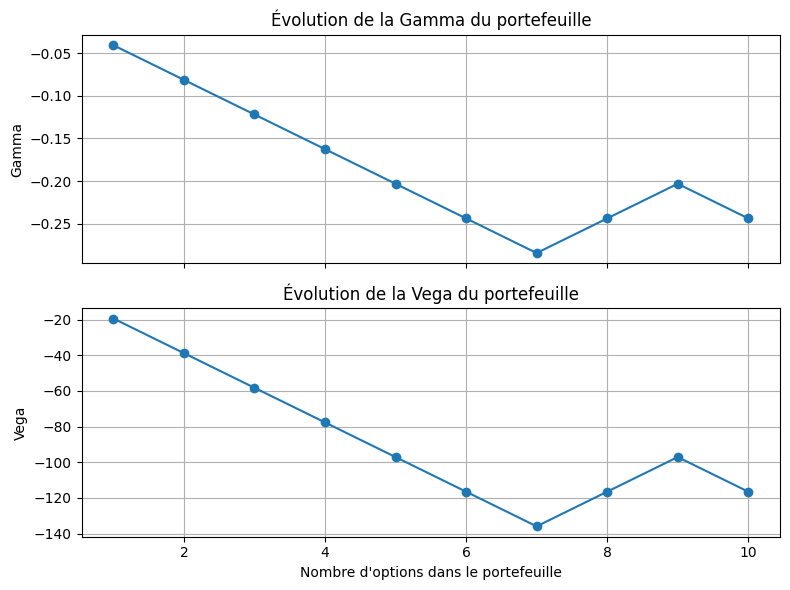

In [51]:
np.random.seed(0)

params = {
    "r": 0.01,
    "q": 0.0,
    "sigma0": 0.2,
    "v": 0.5,
    "rho": -0.3
}

S = 100.0
portfolio = []

n, signs = sample_client_orders(lambda_day=10.0)

gamma_hist = []
vega_hist = []
n_opts = []

for s in signs:
    portfolio.append(create_client_option(s, S, params))

    pg = portfolio_greeks(portfolio, S, params)

    gamma_hist.append(pg["gamma"])
    vega_hist.append(pg["vega"])
    n_opts.append(len(portfolio))

# plots
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axs[0].plot(n_opts, gamma_hist, marker="o")
axs[0].set_title("Évolution de la Gamma du portefeuille")
axs[0].set_ylabel("Gamma")
axs[0].grid(True)

axs[1].plot(n_opts, vega_hist, marker="o")
axs[1].set_title("Évolution de la Vega du portefeuille")
axs[1].set_xlabel("Nombre d'options dans le portefeuille")
axs[1].set_ylabel("Vega")
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [53]:
T_hedge = 30 / 252
hedge = hedging_option(S, T_hedge, params)

H_max = max_hedge_position(pg, hedge)
H = 0.5 * H_max  # hedge partiel

gamma_new = pg["gamma"] + H * hedge["gamma"]
vega_new = pg["vega"] + H * hedge["vega"]

print("Gamma avant:", pg["gamma"])
print("Gamma après:", gamma_new)

print("Vega avant:", pg["vega"])
print("Vega après:", vega_new)


Gamma avant: -0.24378876896339335
Gamma après: -0.12189438448169668
Vega avant: -116.4851949761464
Vega après: -87.41336265592938


In [54]:
kappa = 0.01
dt = 1 / 252

P_prev = portfolio_value(portfolio, S, params)

# on applique le hedge
V = hedge["price"]
cost = transaction_cost(V, H, kappa)

# évolution du marché (petit choc spot)
S_new = S * 1.01

P_curr = portfolio_value(portfolio, S_new, params)
R = compute_reward(P_prev, P_curr, V, H, kappa)

print("Reward:", R)
print("Coût de transaction:", cost)
print("Variation portefeuille:", P_curr - P_prev)


Reward: -3.4458191518908605
Coût de transaction: 0.05954114322877177
Variation portefeuille: -3.3862780086620887
